In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt

sns.set(style="whitegrid")


In [3]:
!git clone https://github.com/sabrinashuhaimi17/Delivery-Time-Prediction.git

Cloning into 'Delivery-Time-Prediction'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 12 (delta 2), reused 12 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (12/12), done.
Resolving deltas: 100% (2/2), done.


In [4]:
!find . -name "requirements.txt"

./Delivery-Time-Prediction/requirements.txt


In [5]:
!pip install -r ./Delivery-Time-Prediction/requirements.txt

In [6]:
!python ./Delivery-Time-Prediction/src/generate_data.py

✅ 'delivery_data.csv' generated successfully!


In [7]:
import os
os.listdir()


['.config', 'Delivery-Time-Prediction', 'delivery_data.csv', 'sample_data']

**Part 1:Data Cleaning & Feature Engineering (Pandas)**

In [8]:
df = pd.read_csv("./delivery_data.csv")
df.head()

,timestamp,distance_km,weather_condition,traffic_level,package_weight,driver_rating,delivery_time_minutes
0,2023-01-11 23:15:00,6.4,Sunny,Low,-1.0,NaN,33.0
1,2023-01-01 14:20:00,7.9,Sunny,High,25.0,3.7,46.0
2,2023-01-27 11:58:00,13.3,Sunny,Medium,25.3,3.8,46.0
3,2023-02-01 01:32:00,11.8,Sunny,Low,11.5,4.2,30.0
4,2023-01-08 20:04:00,7.8,Rainy,Low,19.1,4.6,42.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   timestamp              1000 non-null   object 
 1   distance_km            1000 non-null   float64
 2   weather_condition      1000 non-null   object 
 3   traffic_level          1000 non-null   object 
 4   package_weight         1000 non-null   float64
 5   driver_rating          950 non-null    float64
 6   delivery_time_minutes  1000 non-null   float64
dtypes: float64(4), object(3)
memory usage: 54.8+ KB


In [10]:
df.describe()

,distance_km,package_weight,driver_rating,delivery_time_minutes
count,1000.000000,1000.000000,950.000000,1000.000000
mean,10.500000,14.837700,3.980105,45.880000
std,5.527789,8.702938,0.571388,14.430726
min,1.100000,-1.000000,3.000000,11.000000
25%,5.500000,7.300000,3.500000,35.750000
50%,10.600000,14.950000,4.000000,46.000000
75%,15.100000,22.600000,4.500000,56.000000
max,20.000000,29.900000,5.000000,93.000000


Handle missing values:

driver_rating

In [20]:
#impute missng values- driver_rating with median
df["driver_rating"] = df["driver_rating"].fillna(
    df["driver_rating"].median())

In [21]:
df["driver_rating"].isna().sum()

np.int64(0)

In [22]:
df.head()

,timestamp,distance_km,weather_condition,traffic_level,package_weight,driver_rating,delivery_time_minutes
0,2023-01-11 23:15:00,6.4,Sunny,Low,-1.0,4.0,33.0
1,2023-01-01 14:20:00,7.9,Sunny,High,25.0,3.7,46.0
2,2023-01-27 11:58:00,13.3,Sunny,Medium,25.3,3.8,46.0
3,2023-02-01 01:32:00,11.8,Sunny,Low,11.5,4.2,30.0
4,2023-01-08 20:04:00,7.8,Rainy,Low,19.1,4.6,42.0


Feature extraction

These features are time strongly affects delivery performance.

order_hour

1.   order_hour
*  Captures peak hours
*  Captures traffic and operational lead


2.   order_dayofweek
*   Weekday vs weekend behavior differences


These features are useful for regression problems

In [23]:
#feature extraction
df["timestamp"] = pd.to_datetime(df["timestamp"])

In [29]:
#Create new features
df["order_hour"]= df["timestamp"].dt.hour
df["order_day_ofweek"]= df["timestamp"].dt.dayofweek

In [31]:
df = df.drop(columns=["timestamp"])

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   distance_km            1000 non-null   float64
 1   weather_condition      1000 non-null   object 
 2   traffic_level          1000 non-null   object 
 3   package_weight         1000 non-null   float64
 4   driver_rating          1000 non-null   float64
 5   delivery_time_minutes  1000 non-null   float64
 6   order_hour             1000 non-null   int32  
 7   order_day_ofweek       1000 non-null   int32  
dtypes: float64(4), int32(2), object(2)
memory usage: 54.8+ KB


**PART 2: Pipeline Construction (Prevent Data Leakage)**

In [26]:
# Define features and target
X = df.drop(columns=["delivery_time_minutes"])
y = df["delivery_time_minutes"]

In [27]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

In [33]:
# define column types
numeric_features = X.select_dtypes(include=["int32","float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns


In [35]:
# define transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler()) ])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore")) ])


Reason define transformer:



*  Scaling helps linear models converge properly
*  One-hot encoding converts categories safely
*  handle_unknown="ignore" prevents test-time crashes


In [37]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)])


In [40]:
# full modelling pipeline
from sklearn.linear_model import LinearRegression

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LinearRegression()) ])


**PART 3: Training, Prediction & Evaluation**

In [41]:
# train the pipeline on training set
pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['distance_km', 'package_weight', 'driver_rating', 'hour', 'day_ofweek'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['weather_condition', 'traffic_level'], dtype='object'))])),
                ('model', LinearRegression())])

In [47]:
#predict on the test
y_pred = pipeline.predict(X_test)

In [50]:
# Evaluation Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")




Mean Absolute Error (MAE): 3.72
Root Mean Squared Error (RMSE): 4.73
R² Score: 0.89


MAE - On average, the model’s predicted delivery time is off by approximately 3.7 minutes from the actual delivery time.

RMSE - The RMSE indicates that larger prediction errors are slightly more penalized, resulting in an average error of about 4.7 minutes. This indicates the model is stable and consistent.

R² - The model explains approximately 89% of the variance in delivery time. The value close to 1.0 indicates a strong relationship between features and the target. An R² of 0.89 is very strong.

**BONUS: Actual vs Predicted Plot**


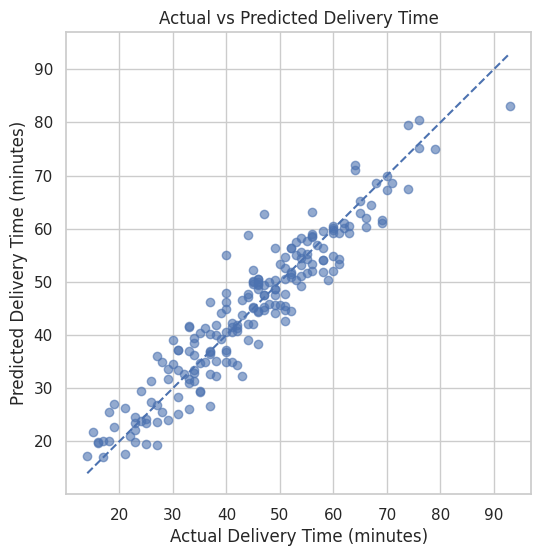

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    linestyle="--"
)

plt.xlabel("Actual Delivery Time (minutes)")
plt.ylabel("Predicted Delivery Time (minutes)")
plt.title("Actual vs Predicted Delivery Time")
plt.show()


Interpretation: Actual vs Predicted Delivery Time Plot

The Actual vs Predicted plot shows that most predictions lie close to the
diagonal reference line, indicating good correspondence between predicted and
actual delivery times. The model performs consistently across most delivery
durations, with slightly higher variance for longer deliveries, which is
expected in real-world scenarios. The limited number of outliers suggests the model is robust.


**Part 4: checking Question 1**

In [52]:
(df["package_weight"] < 0).mean()

np.float64(0.02)

In [55]:
df.loc[df["package_weight"] < 0, "package_weight"].describe()

,package_weight
count,20.0
mean,-1.0
std,0.0
min,-1.0
25%,-1.0
50%,-1.0
75%,-1.0
max,-1.0
